## Q1

In [3]:
number = 1733

In [6]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import re
import os
from sklearn.preprocessing import LabelEncoder

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove special characters and punctuation
    text = re.sub('[^A-Za-z0-9\s]+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def train_word_embeddings(data, embedding_size=100, window_size=5, min_count=1):
    # Preprocess text
    preprocessed_data = [preprocess_text(text) for text in data]
    # Convert preprocessed text to list of sentences
    sentences = [text.split() for text in preprocessed_data]
    # Train word embeddings
    #sentences, vector_size=embedding_size, window=window_size, min_count=min_count, workers=4, epochs=10
    model = Word2Vec(sentences, vector_size=embedding_size, window=window_size, min_count=min_count, workers=4, epochs=10)
    return model

# Load dataset
data = []
labels = []
for label in ['neg', 'pos']:
    folder_path = os.path.join(r'/content/drive/MyDrive/Comments', label)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            data.append(preprocess_text(text))
            labels.append(label)
le = LabelEncoder()
labels = le.fit_transform(labels)
# Split dataset into training, validation and testing subsets
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=number)

# train_data = data[:train_size]
# train_labels = labels[:train_size]
# val_data = data[train_size:train_size+val_size]
# val_labels = labels[train_size:train_size+val_size]
# test_data = data[train_size+val_size:]
# test_labels = labels[train_size+val_size:]

# Train word embeddings
embedding_size = 100
window_size = 3
min_count = 1

word_embeddings = train_word_embeddings(X_train, embedding_size=embedding_size, window_size=window_size, min_count=min_count)


In [8]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=number)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to the same length
max_len = 100

train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert comments to sequences of integers


# Define model architecture
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_size))
for word, i in tokenizer.word_index.items():
    if word in word_embeddings.wv:
        embedding_matrix[i] = word_embeddings.wv[word]

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, embedding_size, input_length=max_len,
                              weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
num_epochs = 10
batch_size = 32

history = model.fit(train_padded, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(val_padded, y_val))
#model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=10, batch_size=32)
# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_padded, y_test, verbose=2)
print('Test Accuracy: ', test_acc)

# Plot confusion matrix
y_pred = model.predict(test_padded)
y_pred=np.round(y_pred,axis=1)
cm = tf.math.confusion_matrix(y_test, y_pred)
print(cm)


Epoch 1/10
547/547 [==============================] - 8s 11ms/step - loss: 0.5513 - accuracy: 0.7238 - val_loss: 0.4632 - val_accuracy: 0.7843
Epoch 2/10
547/547 [==============================] - 6s 10ms/step - loss: 0.4134 - accuracy: 0.8119 - val_loss: 0.4602 - val_accuracy: 0.7840
Epoch 3/10
547/547 [==============================] - 7s 12ms/step - loss: 0.3430 - accuracy: 0.8465 - val_loss: 0.5021 - val_accuracy: 0.7776
Epoch 4/10
547/547 [==============================] - 5s 10ms/step - loss: 0.2944 - accuracy: 0.8718 - val_loss: 0.5160 - val_accuracy: 0.7739
Epoch 5/10
547/547 [==============================] - 7s 14ms/step - loss: 0.2529 - accuracy: 0.8867 - val_loss: 0.6091 - val_accuracy: 0.7784
Epoch 6/10
547/547 [==============================] - 6s 11ms/step - loss: 0.2215 - accuracy: 0.8989 - val_loss: 0.6300 - val_accuracy: 0.7747
Epoch 7/10
547/547 [==============================] - 7s 12ms/step - loss: 0.1991 - accuracy: 0.9053 - val_loss: 0.6415 - val_accuracy: 0.7720

In [24]:
y_pred = model.predict(test_padded)
# y_pred=np.round(y_pred,axis=1)

118/118 [==============================] - 1s 7ms/step


In [27]:
y_test

array([0, 0, 0, ..., 1, 0, 0])

In [28]:
import numpy as np

In [29]:
y_pred2 = np.round(y_pred).flatten()

In [33]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_pred2,y_test)

In [22]:
import seaborn as sns

<Axes: >

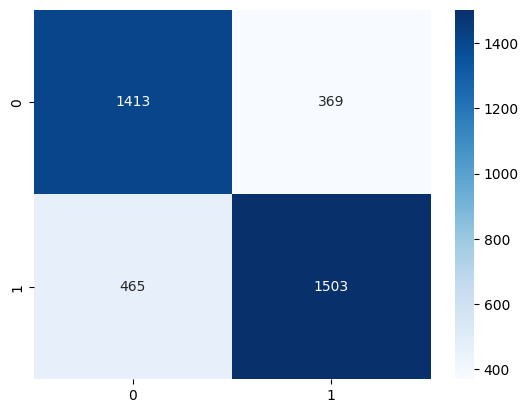

In [36]:
sns.heatmap(cm1, annot=True, cmap='Blues', fmt='g')

In [38]:
model.save('/content/drive/MyDrive/Comments/1_model_including_embedding_layer')

In [37]:
train_padded.shape

(17500, 100)

In [13]:
# Define model architecture
model2 = tf.keras.Sequential([tf.keras.layers.Dense(64, activation='relu',input_shape=(100,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history2 = model2.fit(train_padded, y_train, epochs=10, batch_size=256, validation_data=(val_padded, y_val))

# Evaluate model on test set
test_loss, test_acc = model2.evaluate(test_padded, y_test, verbose=2)
print('Test Accuracy: ', test_acc)

# Plot confusion matrix


Epoch 1/10
69/69 [==============================] - 4s 12ms/step - loss: 4416.9780 - accuracy: 0.5025 - val_loss: 1092.5513 - val_accuracy: 0.4960
Epoch 2/10
69/69 [==============================] - 1s 7ms/step - loss: 1992.9703 - accuracy: 0.5029 - val_loss: 555.2484 - val_accuracy: 0.5045
Epoch 3/10
69/69 [==============================] - 0s 5ms/step - loss: 960.7247 - accuracy: 0.4998 - val_loss: 289.5102 - val_accuracy: 0.5195
Epoch 4/10
69/69 [==============================] - 0s 5ms/step - loss: 457.7003 - accuracy: 0.5074 - val_loss: 150.9700 - val_accuracy: 0.5197
Epoch 5/10
69/69 [==============================] - 0s 4ms/step - loss: 223.7118 - accuracy: 0.5033 - val_loss: 81.9097 - val_accuracy: 0.5091
Epoch 6/10
69/69 [==============================] - 0s 5ms/step - loss: 120.0521 - accuracy: 0.5057 - val_loss: 47.9157 - val_accuracy: 0.5115
Epoch 7/10
69/69 [==============================] - 0s 4ms/step - loss: 71.0078 - accuracy: 0.5025 - val_loss: 29.4899 - val_accuracy:

118/118 [==============================] - 1s 4ms/step


<Axes: >

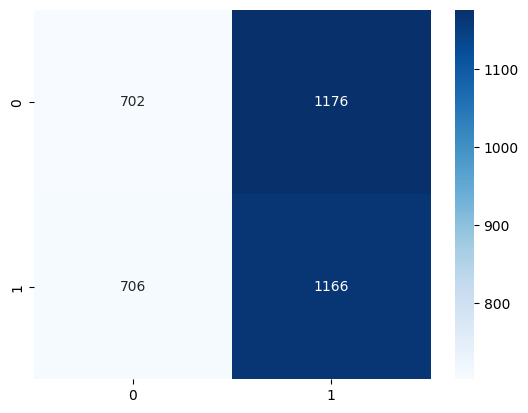

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred21 = model2.predict(test_padded)
y_pred22=np.round(y_pred21).flatten()
cm22 = confusion_matrix(y_test,y_pred22)
sns.heatmap(cm22, annot=True, cmap='Blues', fmt='g')

In [18]:
cm22

array([[ 702,  706],
       [1176, 1166]])

## Q2

In [ ]:
import os
import string
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
roll = 2345

# Load the data
def load_data(root_folder):
    texts, labels = [], []
    for label, subfolder in enumerate(['neg', 'pos']):
        folder_path = os.path.join(root_folder, subfolder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            with open(file_path, encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(label)
    return texts, labels

root_folder = 'comments250k\comments250k'
texts, labels = load_data(root_folder)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, stratify=labels, random_state=roll)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=roll)

# Tokenizer
def simple_tokenizer(text):
    tokens = word_tokenize(text.lower())
    return [token for token in tokens if token not in string.punctuation]

# Create TextDataset and DataLoader
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_seq_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = self.tokenizer(text)[:self.max_seq_length]
        token_ids = [hash(token) % 10000 for token in tokens]
        token_ids += [0] * (self.max_seq_length - len(token_ids))
        return np.array(token_ids), self.labels[idx]

batch_size = 64
max_seq_length = 100

train_dataset = TextDataset(X_train, y_train, simple_tokenizer, max_seq_length)
val_dataset = TextDataset(X_val, y_val, simple_tokenizer, max_seq_length)
test_dataset = TextDataset(X_test, y_test, simple_tokenizer, max_seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n.squeeze(0))
# RNN Model
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        return self.fc(h_n.squeeze(0))

# GRU Model
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(SimpleGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        return self.fc(h_n.squeeze(0))

# Bidirectional 3-layer Stacked LSTM Model
class BiStackedLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers=3):
        super(BiStackedLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat([h_n[-2,:,:], h_n[-1,:,:]], dim=1)  # Concatenate the hidden states of both directions
        return self.fc(h_n)

# Training and evaluation functions
def train_model(model, train_loader, val_loader, device, n_epochs=10, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')

def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return classification_report(y_true, y_pred)

# Train and evaluate the SimpleLSTM model
vocab_size = 10000
embedding_dim = 100
hidden_size = 128
output_size = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

simple_lstm_model = SimpleLSTM(vocab_size, embedding_dim, hidden_size, output_size)
train_model(simple_lstm_model, train_loader, val_loader, device)
classification_report_ = evaluate_model(simple_lstm_model, test_loader, device)
print("Simple LSTM Classification Report:\n", classification_report_)

Epoch 1/10, Train Loss: 0.6908220822793724, Val Loss: 0.6887604432590937
Epoch 2/10, Train Loss: 0.6521522859587287, Val Loss: 0.6536708019547544
Epoch 3/10, Train Loss: 0.6380945688834155, Val Loss: 0.6561519220723944
Epoch 4/10, Train Loss: 0.6009903085710359, Val Loss: 0.6484808194435249
Epoch 5/10, Train Loss: 0.6114181706505101, Val Loss: 0.6374850202414949
Epoch 6/10, Train Loss: 0.4977085384791785, Val Loss: 0.5646135372630621
Epoch 7/10, Train Loss: 0.4162685464333444, Val Loss: 0.5453914919141996
Epoch 8/10, Train Loss: 0.3510406223418069, Val Loss: 0.5568402677269305
Epoch 9/10, Train Loss: 0.3030809630660245, Val Loss: 0.5714961800534847
Epoch 10/10, Train Loss: 0.2513226888203708, Val Loss: 0.6129618332547656
Simple LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75      1875
           1       0.75      0.77      0.76      1875

    accuracy                           0.76      3750
   macro avg   

In [ ]:
import os
import random
import shutil

def split_dataset(data_dir, train_ratio, val_ratio, test_ratio):
    for class_name in ['neg', 'pos']:
        class_dir = os.path.join(data_dir, class_name)
        files = os.listdir(class_dir)
        random.shuffle(files)
        
        train_cnt = int(train_ratio * len(files))
        val_cnt = int(val_ratio * len(files))
        
        train_files = files[:train_cnt]
        val_files = files[train_cnt:train_cnt+val_cnt]
        test_files = files[train_cnt+val_cnt:]
        
        for split, file_list in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            split_dir = os.path.join(data_dir, split, class_name)
            os.makedirs(split_dir, exist_ok=True)
            
            for file in file_list:
                src = os.path.join(class_dir, file)
                dst = os.path.join(split_dir, file)
                shutil.copyfile(src, dst)

data_dir = 'comments250k\comments250k'
split_dataset(data_dir, 0.7, 0.15, 0.15)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.preprocessing import LabelEncoder

class CommentsDataset(Dataset):
    def __init__(self, data_dir, split, vocab=None):
        self.split = split
        self.label_encoder = LabelEncoder()
        self.tokenizer = get_tokenizer('basic_english')
        self.data = []
        self.labels = []
        
        for class_name in ['neg', 'pos']:
            class_dir = os.path.join(data_dir, split, class_name)
            files = os.listdir(class_dir)
            for file in files[:100]:
                with open(os.path.join(class_dir, file), 'r') as f:
                    text = f.read()
                self.data.append(text)
                self.labels.append(class_name)
                
        self.labels = self.label_encoder.fit_transform(self.labels)
        
        if vocab is None:
            self.vocab = build_vocab_from_iterator(self._tokenize_data(), specials=['<pad>', '<unk>'])
        else:
            self.vocab = vocab
    
    def _tokenize_data(self):
        for text in self.data:
            yield self.tokenizer(text)

    def _numericalize(self, text):
        return [self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in self.tokenizer(text)]

    def __getitem__(self, index):
        text = self._numericalize(self.data[index])
        return torch.tensor(text), self.labels[index]
    
    def __len__(self):
        return len(self.data)

def collate_fn(batch):
    data, labels = zip(*batch)
    data = pad_sequence(data, batch_first=True)
    labels = torch.tensor(labels)
    return data, labels

train_dataset = CommentsDataset(data_dir, 'train')
val_dataset = CommentsDataset(data_dir, 'val', vocab=train_dataset.vocab)
test_dataset = CommentsDataset(data_dir, 'test', vocab=train_dataset.vocab)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


c:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x
vocab_size = len(train_dataset.vocab)
embedding_dim = 128
hidden_dim = 256
output_dim = 2

model = SimpleRNN(vocab_size, embedding_dim, hidden_dim, output_dim)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

from sklearn.metrics import classification_report

def predict(model, dataloader, device):
    model.eval()
    predictions = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            predictions.extend(predicted.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return predictions, labels_list

predictions, labels = predict(model, test_dataloader, device)
print('RNN Model',classification_report(labels, predictions, target_names=['neg', 'pos']))


100%|██████████| 110/110 [00:30<00:00,  3.63it/s]


Epoch 1/5, Train Loss: 0.7018, Train Acc: 49.66%, Val Loss: 0.6938, Val Acc: 49.99%


100%|██████████| 110/110 [00:29<00:00,  3.79it/s]


Epoch 2/5, Train Loss: 0.7010, Train Acc: 50.87%, Val Loss: 0.7004, Val Acc: 50.03%


100%|██████████| 110/110 [00:29<00:00,  3.72it/s]


Epoch 3/5, Train Loss: 0.6970, Train Acc: 49.95%, Val Loss: 0.7026, Val Acc: 50.06%


100%|██████████| 110/110 [00:30<00:00,  3.65it/s]


Epoch 4/5, Train Loss: 0.6973, Train Acc: 50.34%, Val Loss: 0.6940, Val Acc: 49.94%


100%|██████████| 110/110 [00:29<00:00,  3.70it/s]


Epoch 5/5, Train Loss: 0.6995, Train Acc: 50.14%, Val Loss: 0.7031, Val Acc: 50.09%


100%|██████████| 109/109 [00:30<00:00,  3.53it/s]

RNN Model               precision    recall  f1-score   support

         neg       0.54      0.01      0.02      3449
         pos       0.50      0.99      0.67      3480

    accuracy                           0.50      6929
   macro avg       0.52      0.50      0.34      6929
weighted avg       0.52      0.50      0.34      6929



In [ ]:
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SimpleLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

vocab_size = len(train_dataset.vocab)
embedding_dim = 128
hidden_dim = 256
output_dim = 2

model = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, output_dim)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

from sklearn.metrics import classification_report

def predict(model, dataloader, device):
    model.eval()
    predictions = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            predictions.extend(predicted.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return predictions, labels_list

predictions, labels = predict(model, test_dataloader, device)
print('LSTM Model',classification_report(labels, predictions, target_names=['neg', 'pos']))


100%|██████████| 110/110 [01:04<00:00,  1.71it/s]


Epoch 1/5, Train Loss: 0.6953, Train Acc: 49.58%, Val Loss: 0.6932, Val Acc: 50.04%


100%|██████████| 110/110 [01:04<00:00,  1.70it/s]


Epoch 2/5, Train Loss: 0.6928, Train Acc: 49.83%, Val Loss: 0.6935, Val Acc: 50.00%


100%|██████████| 110/110 [01:02<00:00,  1.75it/s]


Epoch 3/5, Train Loss: 0.6916, Train Acc: 50.45%, Val Loss: 0.6930, Val Acc: 50.14%


100%|██████████| 110/110 [01:01<00:00,  1.80it/s]


Epoch 4/5, Train Loss: 0.6910, Train Acc: 50.01%, Val Loss: 0.6932, Val Acc: 50.27%


100%|██████████| 110/110 [01:02<00:00,  1.76it/s]


Epoch 5/5, Train Loss: 0.6892, Train Acc: 50.41%, Val Loss: 0.6934, Val Acc: 50.23%


100%|██████████| 109/109 [01:08<00:00,  1.58it/s]


LSTM Model               precision    recall  f1-score   support

         neg       0.74      0.01      0.02      3449
         pos       0.50      1.00      0.67      3480

    accuracy                           0.51      6929
   macro avg       0.62      0.50      0.34      6929
weighted avg       0.62      0.51      0.35      6929



In [ ]:
import torch.nn as nn

class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SimpleGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x
vocab_size = len(train_dataset.vocab)
embedding_dim = 128
hidden_dim = 256
output_dim = 2

model = SimpleGRU(vocab_size, embedding_dim, hidden_dim, output_dim)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

from sklearn.metrics import classification_report

def predict(model, dataloader, device):
    model.eval()
    predictions = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            predictions.extend(predicted.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return predictions, labels_list

predictions, labels = predict(model, test_dataloader, device)
print('GRU Model',classification_report(labels, predictions, target_names=['neg', 'pos']))


100%|██████████| 110/110 [01:35<00:00,  1.15it/s]


Epoch 1/5, Train Loss: 0.6991, Train Acc: 50.31%, Val Loss: 0.6971, Val Acc: 49.97%


100%|██████████| 110/110 [01:39<00:00,  1.10it/s]


Epoch 2/5, Train Loss: 0.6942, Train Acc: 50.12%, Val Loss: 0.6935, Val Acc: 50.21%


100%|██████████| 110/110 [01:42<00:00,  1.07it/s]


Epoch 3/5, Train Loss: 0.6582, Train Acc: 59.76%, Val Loss: 0.5123, Val Acc: 77.20%


100%|██████████| 110/110 [01:38<00:00,  1.11it/s]


Epoch 4/5, Train Loss: 0.3552, Train Acc: 85.58%, Val Loss: 0.2594, Val Acc: 90.12%


100%|██████████| 110/110 [01:41<00:00,  1.08it/s]


Epoch 5/5, Train Loss: 0.1783, Train Acc: 93.53%, Val Loss: 0.2011, Val Acc: 92.74%


100%|██████████| 109/109 [01:45<00:00,  1.04it/s]

GRU Model               precision    recall  f1-score   support

         neg       0.92      0.95      0.93      3449
         pos       0.95      0.92      0.93      3480

    accuracy                           0.93      6929
   macro avg       0.93      0.93      0.93      6929
weighted avg       0.93      0.93      0.93      6929



In [ ]:
import torch.nn as nn

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=3, bidirectional=True, dropout=0.5):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x
vocab_size = len(train_dataset.vocab)
embedding_dim = 128
hidden_dim = 256
output_dim = 2
num_layers = 3
bidirectional = True
dropout = 0.5

model = BiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout)

In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

from sklearn.metrics import classification_report

def predict(model, dataloader, device):
    model.eval()
    predictions = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            predictions.extend(predicted.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return predictions, labels_list

predictions, labels = predict(model, test_dataloader, device)
print('Bi-directional LSTM Model',classification_report(labels, predictions, target_names=['neg', 'pos']))


100%|██████████| 4/4 [00:25<00:00,  6.30s/it]


Epoch 1/5, Train Loss: 0.7007, Train Acc: 49.50%, Val Loss: 0.7090, Val Acc: 50.00%


100%|██████████| 4/4 [00:25<00:00,  6.48s/it]


Epoch 2/5, Train Loss: 0.6968, Train Acc: 50.50%, Val Loss: 0.6935, Val Acc: 48.50%


100%|██████████| 4/4 [00:28<00:00,  7.00s/it]


Epoch 3/5, Train Loss: 0.7031, Train Acc: 44.50%, Val Loss: 0.7109, Val Acc: 50.00%


100%|██████████| 4/4 [00:27<00:00,  6.90s/it]


Epoch 4/5, Train Loss: 0.6974, Train Acc: 48.50%, Val Loss: 0.7007, Val Acc: 50.00%


100%|██████████| 4/4 [00:22<00:00,  5.67s/it]


Epoch 5/5, Train Loss: 0.6977, Train Acc: 48.50%, Val Loss: 0.6952, Val Acc: 50.00%


100%|██████████| 4/4 [00:19<00:00,  4.98s/it]

Bi-directional LSTM Model               precision    recall  f1-score   support

         neg       0.50      1.00      0.67       100
         pos       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200




c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
